In [36]:
import pandas as pd
df = pd.read_csv('data/admission_data.csv')


In [12]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [37]:
X = df.drop('Chance of Admit ', axis=1)
Y = df['Chance of Admit ']

In [21]:
import seaborn as sns

<AxesSubplot:>

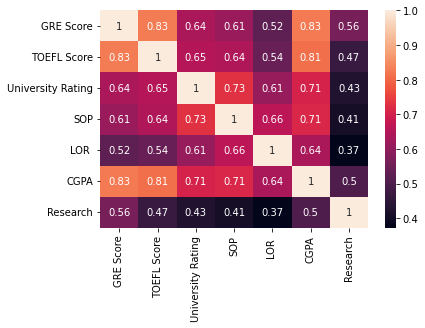

In [25]:
sns.heatmap (X.corr(), annot=True)

In [27]:
import statsmodels.api as sm

model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       Chance of Admit    R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              8178.
Date:                Fri, 01 Jul 2022   Prob (F-statistic):                        0.00
Time:                        16:09:19   Log-Likelihood:                          635.01
No. Observations:                 500   AIC:                                     -1256.
Df Residuals:                     493   BIC:                                     -1227.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


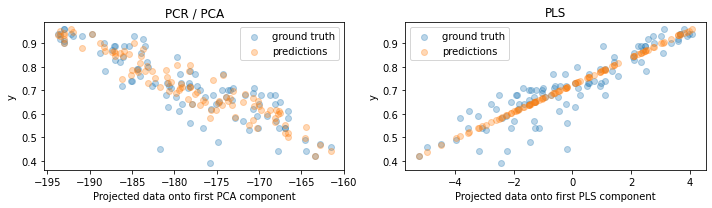

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state=42)

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)


fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

In [118]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.798
PLS r-squared 0.801


In [170]:
n = 3
pcr_2 = make_pipeline(StandardScaler(),PCA(n_components=n), LinearRegression())
pcr_2.fit(X_train.values, y_train.values)
pls_2 = PLSRegression(n_components=n)
pls_2.fit(X_train.values, y_train.values)
print(f"PCR r-squared with 2 components {pcr_2.score(X_test.values, y_test.values):.3f}")
print(f"PLS r-squared with 2 components {pls_2.score(X_test.values, y_test.values):.3f}")

PCR r-squared with 2 components 0.797
PLS r-squared with 2 components 0.810


In [171]:
coeffs = pd.DataFrame(pls_2.coef_.transpose(), columns = X.columns,index=['Coefficient']).sort_values(by='Coefficient',axis=1).T
coeffs


C:\git\gradpredictor\gradpredictor\lib\site-packages\sklearn\cross_decomposition\_pls.py:507: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


,Coefficient
University Rating,0.001033
SOP,0.002322
Research,0.007930
LOR,0.019533
TOEFL Score,0.022647
GRE Score,0.032288
CGPA,0.059169


<AxesSubplot:>

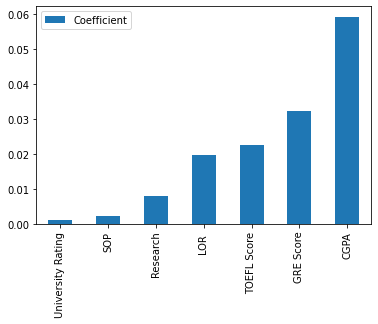

In [172]:
coeffs.plot.bar()

In [173]:
import pickle
import numpy as np
filename = 'C:/git/gradpredictor/models/pls_model.sav'
pickle.dump(pls_2, open(filename, 'wb'))

In [193]:
sop=5
research=1
lor=5
toefl=100
gre=310
gpa=9

new_X = np.array([gre, toefl, 5, sop, lor, gpa, research])
prediction = pls_2.predict(new_X.reshape(1,-1))
print(prediction)


[[0.76318788]]
